In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re
import copy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

from utils.model_analysis_nets import LeNet, VGG16, ResNet20
from utils.load import getGradients, get_total_length, merge_sublists_with_shared_items, initDataset
from utils.load import get_samples, getTopofeature
from CKA import linear_CKA, kernel_CKA
import perscode

import numpy as np
import sympy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy
import networkx as nx
import gif

from sklearn.manifold import MDS

import gudhi as gd
from ripser import Rips
from datetime import datetime


In [2]:


trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
dataset_test = datasets.CIFAR10('data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
attack_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern07-25--17-36-10/local_attack_save/"
normal_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern07-25--17-36-10/local_normal_save/"
round_set = []
client_set_attack = []
client_set_normal = []
modelpth_set = []
for dirpath, dirnames, filenames in os.walk(attack_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        round_set.append(int(re.findall(r'-?\d+', filename)[0]))
        client_set_attack.append(int(re.findall(r'-?\d+', filename)[1]))

round_set = list(set(round_set))
client_set_attack = list(set(client_set_attack))

for dirpath, dirnames, filenames in os.walk(normal_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        client_set_normal.append(int(re.findall(r'-?\d+', filename)[1]))

client_set_normal = list(set(client_set_normal))

print("rounds", round_set, len(round_set))
print("attack", client_set_attack, len(client_set_attack))
print("normal", client_set_normal, len(client_set_normal))
print(len(modelpth_set))

modelpth_dict = {}
for idx, r in enumerate(round_set):
    current_set_normal = []
    current_set_attack = []
    for mt in modelpth_set:
        # print(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_normal:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_normal.append(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_attack:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_attack.append(mt)
        
    modelpth_dict[f'{r}_normal'] = current_set_normal
    modelpth_dict[f'{r}_attack'] = current_set_attack
# print(modelpth_dict)
client_max = min(20,len(client_set_attack),len(client_set_normal))


modelname = ""
if "lenet" in attack_pth:
    modelname = "lenet"
    weightsize = 50
elif "VGG" in attack_pth:
    modelname = "vgg"
    weightsize = 64
elif "resnet" in attack_pth:
    modelname = "resnet"
    weightsize = 64
else:
    assert 0==1


Files already downloaded and verified
rounds [32, 34, 36, 22, 24, 26, 28, 30] 8
attack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 40
normal [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] 60
640


In [3]:
    
corr_set = []
for idround, r in enumerate(round_set):
    if idround >= 1:
        break
    r_modelpth_set = modelpth_dict[f'{r}_normal'][0:client_max] + modelpth_dict[f'{r}_attack'][0:client_max]
    r_corr = np.zeros((client_max * 2, client_max * 2, 1))

    topofeaturelist = []
    gradientlist = []
    model, Dataloader, dataset = initDataset(modelname)
    for idx, modelp1 in enumerate(r_modelpth_set):
            gradientlist.append(getGradients(modelpth=modelp1, model=model, dataloader=Dataloader))
            topofeaturelist.append(getTopofeature(modelpth=modelp1, model=model, dataloader=Dataloader, dataset=dataset))

    vectors = zip(gradientlist, topofeaturelist)
    # for items in vectors:
    #     print(items)
    
    for id1, v1 in enumerate(copy.deepcopy(vectors)):
        if id1 >= client_max * 2:
            break
        for id2, v2 in enumerate(copy.deepcopy(vectors)):
            if id2 >= client_max * 2:
                break
            if id2 <= id1:
                continue
            
            
            corrlist = []

            # print(gradients1)
            acts1 = v1[0]["layer3.0.conv1.weight"]
            acts2 = v2[0]["layer3.0.conv1.weight"]
            acts1 = acts1.cpu().reshape((weightsize,-1))
            acts2 = acts2.cpu().reshape((weightsize,-1))
            fv1 = v1[1].reshape((5,-1))
            fv2 = v2[1].reshape((5,-1))
            # print(acts1-acts2)
            # print(fv1)
            l = linear_CKA(acts1.T, acts2.T)
            k = kernel_CKA(acts1.T, acts2.T)
            lfv = linear_CKA(fv1, fv2)
            kfv = linear_CKA(fv1, fv2)
            corrlist.append((l+k+lfv+kfv)/4)

            r_corr[id1][id2] = np.array(corrlist)
    
    corr_set.append(r_corr)
print(len(corr_set))
#     for id1, g1 in enumerate(gradientlist):
#         if id1 >= client_max * 2:
#             break
#         for id2, g2 in enumerate(gradientlist):
#             if id2 >= client_max * 2:
#                 break
#             if id2 <= id1:
#                 continue
            
            
#             corrlist = []

#             # print(gradients1)
#             acts1 = g1["layer3.0.conv1.weight"]
#             acts2 = g2["layer3.0.conv1.weight"]
#             acts1 = acts1.cpu().reshape((weightsize,-1))
#             acts2 = acts2.cpu().reshape((weightsize,-1))
#             # print(acts1-acts2)
#             l = linear_CKA(acts1.T, acts2.T)
#             k = kernel_CKA(acts1.T, acts2.T)
#             corrlist.append((l+k)/2)

#             r_corr[id1][id2] = np.array(corrlist)
#     corr_set.append(r_corr)

# print(len(corr_set))
    

Files already downloaded and verified
1


# PCODE

(40, 40)


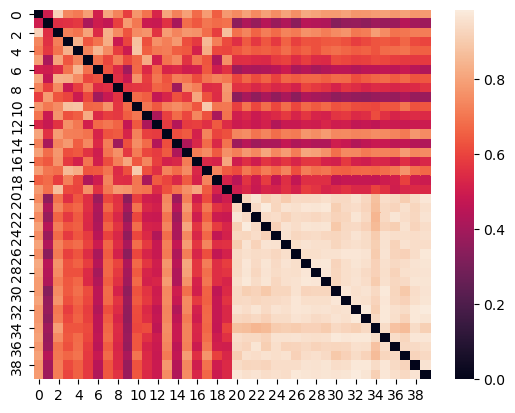

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


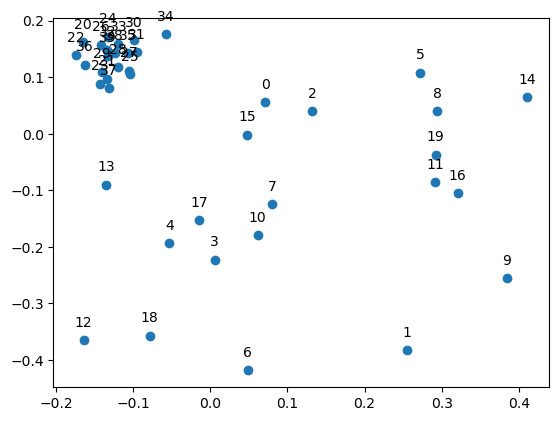

d 0 0 0.0 inf []
d 0 1 0.0 0.26650183828612395 [[17, 18]]
d 0 2 0.0 0.24213189630708964 [[3, 12]]
d 0 3 0.0 0.22146291698464382 [[3, 14]]
d 0 4 0.0 0.21949863410262105 [[8, 19]]
d 0 5 0.0 0.21721004444835712 [[1, 9]]
d 0 6 0.0 0.19869120029861354 [[2, 5]]
d 0 7 0.0 0.19370378873049576 [[0, 13]]
d 0 8 0.0 0.19207949959140092 [[16, 19]]
d 0 9 0.0 0.19038099176682732 [[9, 16]]
d 0 10 0.0 0.18889859539304288 [[15, 27]]
d 0 11 0.0 0.18078498524450914 [[0, 27]]
d 0 12 0.0 0.18022525115295562 [[5, 11]]
d 0 13 0.0 0.17682931039883165 [[3, 7]]
d 0 14 0.0 0.1662584901590186 [[2, 7]]
d 0 15 0.0 0.15223172628098014 [[4, 6]]
d 0 16 0.0 0.13040643764479665 [[2, 19]]
d 0 17 0.0 0.12508869188530158 [[3, 10]]
d 0 18 0.0 0.11751821277984298 [[4, 10]]
d 0 19 0.0 0.10080773576685065 [[10, 17]]
d 0 20 0.0 0.08177448581134572 [[0, 2]]
d 0 21 0.0 0.0546241814037034 [[34, 38]]
d 0 22 0.0 0.03845561084329585 [[25, 37]]
d 0 23 0.0 0.03509955994535119 [[24, 32]]
d 0 24 0.0 0.03474986559869131 [[25, 27]]
d 0 25 0

In [13]:
%matplotlib inline
for corr in corr_set:
    data = 1 - corr.reshape(-1, 2 * client_max) - corr.reshape(-1, 2 * client_max).T
    print(data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()
    sns.heatmap(1-data)
    plt.show()

    # Apply Multidimensional Scaling
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
    mds_results = mds.fit_transform(data)

    # Plot the points
    plt.scatter(mds_results[:, 0], mds_results[:, 1])

    for i, points in enumerate(mds_results):
        plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.show()

    rips_complex = gd.RipsComplex(distance_matrix=data, max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence()

    # filtration = simplex_tree.get_filtration()
    # gd.plot_persistence_barcode(persistence=persistence)
    # plt.show()
    
    count = 0
    results = []
    for (birth_value, death_value), d in [(i[1], i[0]) for i in persistence if i[0] == 0]:
        tolerance = 1e-6
        birth_simplices = []
        death_simplices = []
        filtration = simplex_tree.get_filtration()

        for simplex, filtration_value in filtration:
            # print(filtration_value, birth_value)
            if abs(filtration_value - birth_value) < tolerance:
                # print(simplex)
                birth_simplices.append(simplex)
            elif abs(filtration_value - death_value) < tolerance or (death_value == np.Inf and d != 0):
                death_simplices.append(simplex)
        # print(birth_simplices)

        # involved_points = set()

        # for birth_simplex in birth_simplices:
        #     for death_simplex in death_simplices:
        #         if set(birth_simplex).issubset(death_simplex):
        #             involved_points.update(birth_simplex)
        #             involved_points.update(death_simplex)
        
        # involved_points_b = (merge_sublists_with_shared_items(birth_simplices))
        involved_points_d = (merge_sublists_with_shared_items(death_simplices))

        # if len(involved_points_b) >= 0 : 
        #     print('b',count, birth_value, death_value, involved_points_b) 
        if len(involved_points_d) >= 0 : 
            print('d', d, count, birth_value, death_value, involved_points_d) 
            results.append([death_value, involved_points_d])
        count += 1
    
    a = []
    for [death_value, concern_points] in results:
        for c in concern_points:
            # print(c)
            a.append(c)
            
    for i in range(0, len(a)):
        if (np.unique(a[i:len(a)]).shape[0] == client_max*2):
            continue
        merged = merge_sublists_with_shared_items(a[i:len(a)])
        print("persistence =", results[i][0], merged)
        
        sub_pers = []
        min_length = float('Inf')
        for sub_points in merged:
            if (len(sub_points) <= 1):
                continue
            min_length = min(min_length, len(sub_points))
            sub_diagram = gd.RipsComplex(distance_matrix=np.array(data)[sub_points][:,sub_points], max_edge_length=100)
            sub_simplex_tree = sub_diagram.create_simplex_tree(max_dimension=2)
            sub_persistence = sub_simplex_tree.persistence()
            sub_pd = np.array([[b, d] for dim, (b, d) in sub_persistence if (dim == 0) and (d != float('inf'))])
            sub_pers.append(sub_pd)

        if (len(sub_pers) > 1 and min_length > 1):
            pbow = perscode.PBoW(N = min(5, min_length), normalize = False)
            pbow_diagrams  = pbow.transform(sub_pers)
            print("pbow:")
            print(pbow_diagrams)
            pbow_distance = np.zeros((len(pbow_diagrams),len(pbow_diagrams)))
            for i in range(len(pbow_diagrams)):
                for j in range(len(pbow_diagrams)):
                    pbow_distance[i][j] = np.linalg.norm(pbow_diagrams[i] - pbow_diagrams[j])
            print(pbow_distance)

        print("score x{}: ".format(get_total_length(merged)/client_max/2),end='')
        for j in merged:
            print([np.mean(np.array(j) >= client_max)], end=' ')
        print()


    group = np.zeros((client_max*2,client_max*2))
    for i in merge_sublists_with_shared_items(a)[0]:
        group[i][i] = 1
    # df=pd.DataFrame(group)
    # plot=seaborn.heatmap(df)
    # plt.show()


    # diagrams = np.array([[b, d] for dim, (b, d) in persistence if (dim == 0) and (d != float('inf'))])
    # print(diagrams.shape, diagrams)


In [ ]:
for corr in corr_set:
    data = 1 - corr.reshape(-1, 2 * client_max) - corr.reshape(-1, 2 * client_max).T
    np.savetxt('./data/saved/corr.txt', data)